In [1]:
%env CUDA_VISIBLE_DEVICES=3
%env LIBRARY_PATH=/usr/local/cuda/lib64
import sys
import os
sys.path.append(os.path.expanduser("~/.local/lib/python3.6/site-packages/"))

env: CUDA_VISIBLE_DEVICES=3
env: LIBRARY_PATH=/usr/local/cuda/lib64


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

<h1 align="center"> Image Captioning </h1>

In this notebook you will teach a network to do image captioning
![img](https://media.licdn.com/dms/image/C4D12AQH-T7BYWr9clg/article-inline_image-shrink_1500_2232/0?e=2120536800&v=alpha&t=RrGrsyl8QPtDQjdKKw6VpEbJrTq1Dnigk89_t9vhbfw)



#### Alright, here's our plan:
1. Take a pre-trained inception v3 to vectorize images
2. Stack an LSTM on top of it
3. Train the thing on [MSCOCO](http://cocodataset.org/#download)

In [3]:
# Please eithrer download data from https://yadi.sk/d/b4nAwIE73TVcp5 or generate it manually.

### Data preprocessing

In [4]:
%%time
# Read Dataset
import numpy as np
import json

img_codes = np.load(os.path.expanduser("~/data/DL_data/data/image_codes.npy"))
captions = json.load(open(os.path.expanduser("~/data/DL_data/data/captions_tokenized.json")))

CPU times: user 172 ms, sys: 396 ms, total: 568 ms
Wall time: 569 ms


### Data structure

To save your time, we've already vectorized all MSCOCO17 images with a pre-trained inception_v3 network from [torchvision](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py).

The whole process takes anywhere between a day on CPU and 10min on 3x tesla m40. If you want to play with that yourself, [you're welcome](https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b).

In [5]:
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


As you can see, all captions are already tokenized and lowercased. We now want to split them and add some special tokens for start/end of caption.

In [6]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]


You don't want your network to predict a million-size vector of probabilities at each step, so we're gotta make some cuts. 

We want you to __count the occurences of each word__ so that we can decide which words to keep in our vocabulary.

In [7]:
# Build a Vocabulary
from collections import Counter
word_counts = Counter()

#Compute word frequencies for each word in captions. See code above for data structure
for caption_image in captions:
    for caption in caption_image:
        word_counts.update(caption)

In [8]:
vocab  = ['#UNK#', '#START#', '#END#', '#PAD#']
vocab += [k for k, v in word_counts.items() if v >= 5 if k not in vocab]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [9]:
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#']
bos_ix = word_to_index['#START#']


def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [10]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[   1,   24,  262,  140,    6,  159,   14,   24,  858,  155,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  155,    2,    3,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   41,   18,  903,   35,  620,  155,    2,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   45,  115,  262,   41,   53,   18,  620, 1525,   77,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  123,   58,   45,  276,
        3641,   24, 3642,   35,   45, 1128,   12,    2]], dtype=int32)

### Building our neural network

As we mentioned earlier, we shall build an rnn "language-model" conditioned on vectors from the convolutional part. 

![img](https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png)
_image: http://bit.ly/2FKnqHm_


We'll unbox the inception net later to save memory, for now just pretend that it's available.


In [11]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [12]:
def to_one_hot(y, n_dims=None):
    """ Take integer y (tensor or variable) with n dims and convert it to 1-hot representation with n+1 dims. """
    y_tensor = y.data.cpu() if isinstance(y, Variable) else y
    y_tensor = y_tensor.type(torch.LongTensor).view(-1, 1)
    n_dims = n_dims if n_dims is not None else int(torch.max(y_tensor)) + 1
    y_one_hot = torch.zeros(y_tensor.size()[0], n_dims).scatter_(1, y_tensor, 1)
    y_one_hot = y_one_hot.view(*y.shape, -1)
    return Variable(y_one_hot) if isinstance(y, Variable) else y_one_hot

In [13]:
class CaptionNet(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048):
        """ A recurrent 'head' network for image captioning. See scheme above. """
        super(self.__class__, self).__init__()
         
        # a layer that converts conv features to 
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)
        
        # recurrent part, please create the layers as per scheme above.

        # create embedding for input words. Use the parameters (e.g. emb_size).
        self.emb = nn.Embedding(n_tokens, emb_size)
            
        # lstm: create a recurrent core of your network. Use either LSTMCell or just LSTM. 
        # In the latter case (nn.LSTM), make sure batch_first=True
        self.lstm = nn.LSTM(emb_size, lstm_units, num_layers=2, dropout=0.5) #batch_first=True)
            
        # create logits: linear layer that takes lstm hidden state as input and computes one number per token
        self.logits = nn.Linear(lstm_units, n_tokens) 
        
    def forward(self, image_vectors, captions_ix):
        """ 
        Apply the network in training mode. 
        :param image_vectors: a Variable containing inception vectors. shape: [batch, cnn_feature_size]
        :param captions_ix: a Variable containing captions as matrix. shape: [batch, word_i]. 
            padded with pad_ix
        :returns: logits for next token at each tick, shape: [batch, word_i, n_tokens]
        """
        eps=1e-30
        initial_cell = self.cnn_to_c0(image_vectors)
        initial_hid = self.cnn_to_h0(image_vectors)

        # compute embeddings for captions_ix
        captions_emb = self.emb(captions_ix).transpose(0, 1)

        # apply recurrent layer to captions_emb. 
        # 1. initialize lstm state with initial_* from above
        # 2. feed it with captions. Mind the dimension order in docstring
        # 3. compute logits for next token probabilities
        # Note: if you used nn.LSTM, you can just give it (initial_cell[None], initial_hid[None]) as second arg
            
        # I return  [caption_length, batch, lstm_units]
        # lstm_out should be lstm hidden state sequence of shape [batch, caption_length, lstm_units]
        lstm_out, _ = self.lstm(captions_emb, (torch.cat((initial_hid[None], initial_hid[None]), dim=0),
                                               torch.cat((initial_cell[None], initial_cell[None]), dim=0)))
        
        # compute logits from lstm_out 
        logits = []

        for row in lstm_out:
            logits.append(self.logits(row))
        
        return torch.stack(logits, dim=1)

In [14]:
network = CaptionNet(n_tokens)

In [15]:
dummy_img_vec = Variable(torch.randn(len(captions[0]), 2048))
dummy_capt_ix = Variable(torch.LongTensor(as_matrix(captions[0])))

dummy_logits = network.forward(dummy_img_vec, dummy_capt_ix)

print('shape:', dummy_logits.shape)
assert dummy_logits.shape == (dummy_capt_ix.shape[0], dummy_capt_ix.shape[1], n_tokens)

shape: torch.Size([5, 16, 10403])


In [16]:
def compute_loss(network, image_vectors, captions_ix):
    """
    :param image_vectors: a Variable containing inception vectors. shape: [batch, cnn_feature_size]
    :param captions_ix: a Variable containing captions as matrix. shape: [batch, word_i]. 
        padded with pad_ix
    :returns: crossentropy (neg llh) loss for next captions_ix given previous ones. Scalar float Variable
    """
    
    # captions for input - all except last cuz we don't know next token for last one.
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous()
    
    # apply the network, get predictions for captions_ix_next
    logits_for_next = network.forward(image_vectors, captions_ix_inp)
    
    
    # compute the loss function between logits_for_next and captions_ix_next
    # Use the mask, Luke: make sure that predicting next tokens after EOS do not contribute to loss
    # you can do that either by multiplying elementwise loss by (captions_ix_next != pad_ix)
    # or by using ignore_index in some losses.
    
    log_probs = F.log_softmax(logits_for_next, dim=-1)
    crossentropy = - torch.sum(log_probs * to_one_hot(captions_ix_next, n_tokens).cuda(), dim = -1)
    
    mask = (captions_ix_next != pad_ix).type(torch.cuda.FloatTensor)
    loss = torch.sum(crossentropy * mask) / torch.sum(mask)
    
    return loss

In [18]:
dummy_loss = compute_loss(network, dummy_img_vec, dummy_capt_ix)

assert dummy_loss.shape == torch.Size([1]), 'loss must be scalar'
assert dummy_loss.data.numpy() > 0, "did you forget the 'negative' part of negative log-likelihood"

dummy_loss.backward()

assert all(param.grad is not None for param in network.parameters()), \
        'loss should depend differentiably on all neural network weights'

RuntimeError: Expected object of type Variable[torch.FloatTensor] but found type Variable[torch.cuda.FloatTensor] for argument #1 'other'

Create ~~adam~~ your favorite optimizer for the network.

In [ ]:
#<YOUR CODE>
# I do below before training

# Training

* First implement the batch generator
* Than train the network as usual

In [17]:
from sklearn.model_selection import train_test_split
captions = np.array(captions)
train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(img_codes, captions,
                                                                                test_size=0.1,
                                                                                random_state=42)

In [18]:
from random import choice

def generate_batch(img_codes, captions, batch_size, max_caption_len=None, compute_metric=False):
    
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)
    
    #get images
    batch_images = img_codes[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick one from a set of captions for each image
    batch_captions = list(map(choice,captions_for_batch_images))
    
    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    if not compute_metric:
        return Variable(torch.FloatTensor(batch_images)).cuda(), Variable(torch.LongTensor(batch_captions_ix)).cuda()
    else:
        return Variable(torch.FloatTensor(batch_images)).cuda(), Variable(torch.LongTensor(batch_captions_ix)).cuda(),\
               captions_for_batch_images

In [19]:
generate_batch(img_codes,captions,3)

(Variable containing:
  0.1018  0.0761  0.3753  ...   0.0021  0.7146  1.0916
  0.0471  0.1286  0.2087  ...   0.3431  0.2291  0.0262
  0.4433  0.2528  0.4047  ...   0.0897  0.7087  0.2297
 [torch.cuda.FloatTensor of size 3x2048 (GPU 0)], Variable containing:
     1    24  2688  1154  1119   185   183    45  1432    12     2     3
     1     4    94   107    43     6    45  1026   374  1045    12     2
     1    24    29    78    24   732     6    45   733    12     2     3
 [torch.cuda.LongTensor of size 3x12 (GPU 0)])

### Main loop

Train on minibatches just as usual. Evaluate on val from time to time.

##### TIps
* If training loss has become close to 0 or model produces garbage,
    double-check that you're predicting __next__ words, not current or t+2'th words.
* If the model generates fluent captions that have nothing to do with the images
 * this may be due to recurrent net not receiving image vectors.
 * alternatively it may be caused by gradient explosion, try clipping 'em or just restarting the training
 * finally, you may just need to train the model a bit more


* Crossentropy is a poor measure of overfitting
 * Model can overfit validation crossentropy but keep improving validation quality.
 * Use human _(manual)_ evaluation or try automated metrics: [cider](https://github.com/vrama91/cider) or [bleu](https://www.nltk.org/_modules/nltk/translate/bleu_score.html)
 

* We recommend you to periodically evaluate the network using the next "apply trained model" block
 *  its safe to interrupt training, run a few examples and start training again
 
* The typical loss values should be around 3~5 if you average over time, scale by length if you sum over time. The reasonable captions began appearing at loss=2.8 ~ 3.0
 

In [20]:
from nltk.translate.bleu_score import sentence_bleu

In [21]:
from IPython import display
from tqdm import tqdm, trange #or use tqdm_notebook,tnrange
import time

train_loss_history = []
val_loss_history = []
train_mae_history = []
val_mae_history = []
val_bleu_history = []

In [22]:
network = CaptionNet(n_tokens).cuda()
opt = torch.optim.Adam(network.parameters(), lr=1e-3)

In [23]:
batch_size = 128  # adjust me
n_epochs = 100  # adjust me
n_batches_per_epoch = 64  # adjust me
n_validation_batches = 10  # how many batches are used for validation after each epoch

In [24]:
max_len = 100
temp = 5

In [29]:
#n_epochs=500

In [25]:
#opt = torch.optim.Adam(network.parameters(), lr=1e-3 / 2)

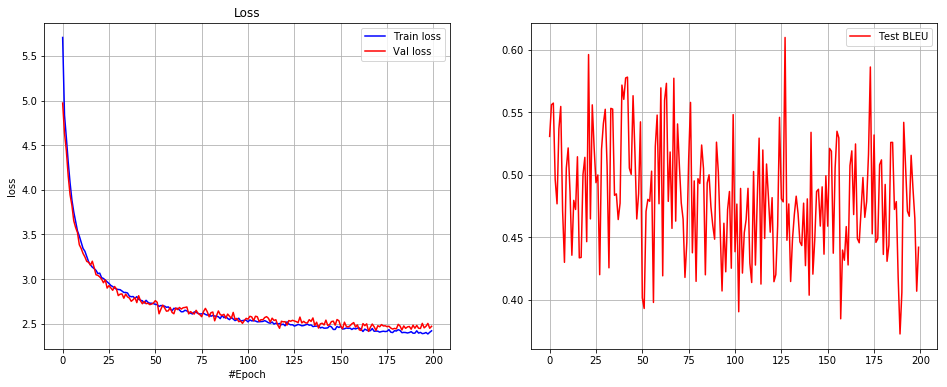

Epoch 100 of 100 took 39.662s
  training loss (in-iteration): 	2.418788
  validation loss:		2.469380
Finished!


In [34]:
from tqdm import tqdm

for epoch in range(n_epochs):
    start_time = time.time()     
    train_loss=0
    network.train(True)
    for _ in tqdm(range(n_batches_per_epoch)):
        
        loss_t = compute_loss(network, *generate_batch(train_img_codes, train_captions, batch_size))
        
        
        # clear old gradients; do a backward pass to get new gradients; then train with opt
        loss_t.backward()
        opt.step()
        opt.zero_grad()
        
        train_loss += loss_t.data.cpu().numpy()[0]
        
    train_loss /= n_batches_per_epoch
    train_loss_history.append(train_loss)
    
    val_loss=0
    bleu_score = 0
    network.train(False)
    for _ in range(n_validation_batches):
        loss_t = compute_loss(network, *generate_batch(val_img_codes, val_captions, batch_size))
        val_loss += loss_t.data.cpu().numpy()[0]

        
        batch_im, batch_caption, captions_for_image = generate_batch(val_img_codes, val_captions, 1,
                                                                     compute_metric=True)
        caption_prefix = ["#START#",]
        for _ in range(max_len):
            prefix_ix = as_matrix([caption_prefix])
            prefix_ix = Variable(torch.LongTensor(prefix_ix), volatile=True).cuda()        
            next_word_logits = network.forward(batch_im, prefix_ix)[0, -1]
            next_word_probs = F.softmax(next_word_logits, -1).data.cpu().numpy()

            assert len(next_word_probs.shape) ==1, 'probs must be one-dimensional'
            next_word_probs = next_word_probs ** temp / np.sum(next_word_probs ** temp) # apply temperature  
            
            next_word = vocab[np.argmax(next_word_probs)]
            caption_prefix.append(next_word)

            if next_word=="#END#":
                break        

        bleu_score += sentence_bleu(captions_for_image[0], caption_prefix)

        
    val_loss /= n_validation_batches
    val_loss_history.append(val_loss)
    
    bleu_score /= n_validation_batches
    val_bleu_history.append(bleu_score)    
    
    
    display.clear_output(wait=True)
    #plt.figure(figsize=(8, 6))
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
    ax1.set_title("Loss")
    ax1.set_xlabel("#Epoch")
    ax1.set_ylabel("loss")
    ax1.plot(train_loss_history, 'b', label='Train loss')
    ax1.plot(val_loss_history, 'r', label='Val loss')
    #ax1.plot(ewma(np.array(train_loss), span=10),'r',label='ewm val loss')
    ax1.legend(loc='best')
    ax1.grid()
    #ax1.set_ylim(0, 1)
    
    ax2.plot(val_bleu_history, 'r', label='Test BLEU')
    ax2.legend(loc='best')
    ax2.grid()
    
    plt.show()
    
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, n_epochs, time.time() - start_time))

    print("  training loss (in-iteration): \t{:.6f}".format(train_loss_history[-1]))
    print("  validation loss:\t\t{:.6f}".format(val_loss_history[-1]))

    #print("  training mae (in-iteration): \t{:.3f}".format(train_mae_history[-1]))
    #print("  validation mae:\t\t{:.3f}".format(val_mae_history[-1]))  

print("Finished!")

### Apply trained model

Let's unpack our pre-trained inception network and see what our model is capable of.

In [35]:
from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False)

inception = inception.cuda()

### Generate caption

The function below creates captions by sampling from probabilities defined by the net.

The implementation used here is simple but inefficient (quadratic in lstm steps). We keep it that way since it isn't a performance bottleneck.

In [36]:
def generate_caption(image, caption_prefix = ("#START#",), 
                     t=1, sample=True, max_len=100):
    
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    
    image = Variable(torch.FloatTensor(image.transpose([2, 0, 1])), volatile=True).cuda()
    
    vectors_8x8, vectors_neck, logits = inception(image[None])
    caption_prefix = list(caption_prefix)
    
    for _ in range(max_len):
        
        prefix_ix = as_matrix([caption_prefix])
        prefix_ix = Variable(torch.LongTensor(prefix_ix), volatile=True).cuda()
        next_word_logits = network.forward(vectors_neck, prefix_ix)[0, -1]
        next_word_probs = F.softmax(next_word_logits, -1).data.cpu().numpy()
        
        
        assert len(next_word_probs.shape) ==1, 'probs must be one-dimensional'
        next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature

        if sample:
            next_word = np.random.choice(vocab, p=next_word_probs) 
        else:
            next_word = vocab[np.argmax(next_word_probs)]

        caption_prefix.append(next_word)

        if next_word=="#END#":
            break
            
    return caption_prefix

In [37]:
from matplotlib import pyplot as plt
from scipy.misc import imresize
%matplotlib inline

#sample image
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O img.jpg
img = plt.imread('img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

--2018-05-10 01:32:11--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 151.101.48.70
Connecting to pixel.nymag.com (pixel.nymag.com)|151.101.48.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 107928 (105K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>] 105.40K  --.-KB/s    in 0.03s   

2018-05-10 01:32:12 (3.63 MB/s) - ‘img.jpg’ saved [107928/107928]



/opt/conda/anaconda3/lib/python3.6/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/opt/conda/anaconda3/lib/python3.6/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


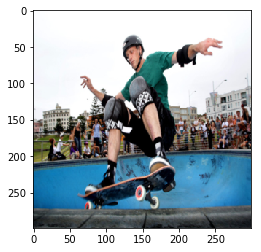

In [38]:
plt.imshow(img)

In [39]:
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

a man riding a skateboard down a ramp .
a man riding a skateboard down a ramp .
a skateboarder doing a trick on a skateboard .
a man riding a skateboard down a ramp .
a man riding a skateboard down a ramp .
a man riding a skateboard down a ramp .
a man riding a skateboard down the side of a ramp .
a man riding a skateboard down a ramp .
a skateboarder performing a trick on a skate board .
a skateboarder is doing a trick on a ramp .


--2018-05-10 01:32:30--  http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Resolving ccanimalclinic.com (ccanimalclinic.com)... 64.207.177.234
Connecting to ccanimalclinic.com (ccanimalclinic.com)|64.207.177.234|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106870 (104K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>] 104.37K  --.-KB/s    in 0.1s    

2018-05-10 01:32:30 (910 KB/s) - ‘img.jpg’ saved [106870/106870]



/opt/conda/anaconda3/lib/python3.6/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/opt/conda/anaconda3/lib/python3.6/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


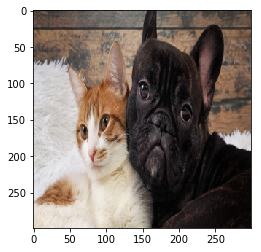

a black and white cat laying on a black blanket .
a black and white cat laying on a bed .
a black and white cat standing on a bed .
a black and white cat laying on a bed .
a black and white cat laying on a bed .
a black and white cat is laying on a bed .
a black and white cat laying on a bed .
a black and white cat sitting on a bed .
a black and white cat laying on a red blanket .
a black and white cat laying on a bed .


In [40]:
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O img.jpg
img = plt.imread('img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

# Demo
### Find at least 10 images to test it on.
* Seriously, that's part of an assignment. Go get at least 10 pictures to get captioned
* Make sure it works okay on __simple__ images before going to something more comples
* Photos, not animation/3d/drawings, unless you want to train CNN network on anime
* Mind the aspect ratio

In [74]:
os.listdir("my_pics")

['traffic.jpg', 'cow.jpg', 'hedgehog.jpeg', 'football.jpg']

/opt/conda/anaconda3/lib/python3.6/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/opt/conda/anaconda3/lib/python3.6/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


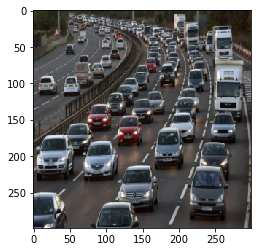

a large truck is parked in a lot .
a large group of people walking down a street .
a large truck is parked on the side of the road .
a group of people walking down a street with a large clock .
a large group of people walking down a street .
a large group of people walking down a street .
a large truck is parked in the middle of the road .
a large white truck is parked next to a building .
a large white truck is parked in a lot .
a large group of people walking down a street .


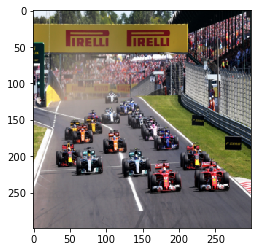

a train yard with a lot of people on it
a group of people standing on a city street .
a train is traveling down the tracks in a city .
a train station with a lot of people on it
a large group of people standing around a train station .
a group of people standing on a city street .
a train yard with a lot of people on it
a group of people standing around a train station .
a large group of people standing around a train station .
a train yard with a lot of people on it


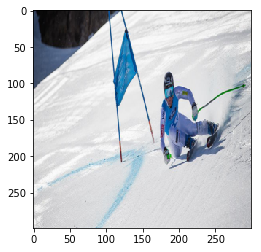

a person riding skis down a snow covered slope .
a person riding skis down a snow covered slope .
a person riding skis down a snow covered slope .
a man riding skis down a snow covered slope .
a person riding skis down a snow covered slope .
a person riding skis down a snow covered slope .
a person riding skis down a snow covered slope .
a man riding skis down a snow covered slope .
a person riding skis down a snow covered slope .
a person riding skis down a snow covered slope .


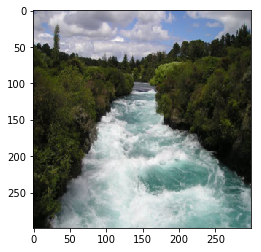

a large body of water with a large body of water .
a large white and blue train is coming down the tracks .
a large white and blue train is on the tracks .
a view of a mountain with a large body of water .
a large body of water with a mountain in the background .
a large body of water with a large body of water .
a large body of water with a large body of water .
a large body of water with a large body of water .
a person is riding a wave on a surfboard .
a large white and blue train is coming down the river


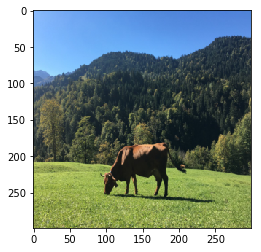

a cow standing in a field with a cow in the background
a cow standing in a field with a cow in the background .
a cow is standing in a field with a cow in the background .
a cow standing in the grass near a fence .
a cow standing in a field with a cow in the background .
a cow standing in a field with a cow in the background .
a cow is standing in a field with a cow in the background .
a cow standing in the grass near a tree .
a cow is standing in a field of grass .
a cow standing in a field with a cow in the background .


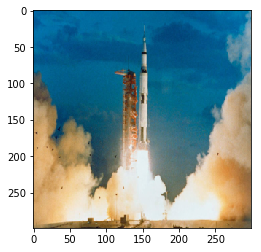

a large white airplane is flying in the sky
a large white airplane flying in the sky .
a large white and white plane flying in the sky .
a large white airplane is flying in the sky .
a large white plane flying in the sky .
a large white airplane is flying in the sky .
a large white and white plane flying in the sky .
a large white airplane is flying in the sky .
a very large , white and blue plane flying in the sky .
a large white airplane is flying in the sky .


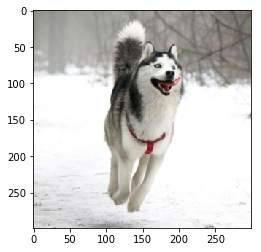

a group of dogs standing on a beach .
a dog is standing on a beach with a dog .
a man and a dog are standing in the snow .
a man riding a white horse in the snow .
a man and a dog are standing on a beach .
a small dog is standing in the snow .
a group of dogs standing on the beach .
a dog is standing on the beach with a dog .
a man is holding a dog in the snow .
a group of dogs that are standing in the snow .


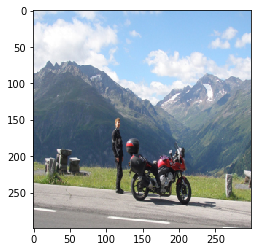

a man riding a motorcycle down a dirt road .
a man riding a motorcycle down a dirt road .
a man riding a bike down a dirt road .
a man riding a motorcycle down a dirt road .
a man riding a motorcycle down a road .
a man riding a motorcycle down a road .
a man riding a motorcycle down a road .
a man riding a motorcycle down a dirt road .
a person riding a motorcycle on a dirt road
a man riding a motorcycle down a dirt road .


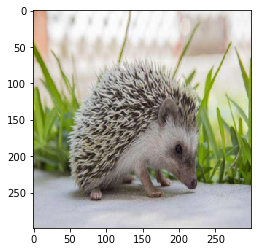

a woman is holding a large teddy bear .
a woman holding a child in her hand .
a man is holding a large white frisbee .
a small child is holding a pair of scissors .
a woman holding a white frisbee in her hand .
a woman holding a pink frisbee in her hand .
a woman holding a red and white surfboard .
a woman holding a red and white surfboard .
a person holding a small child in a blue shirt
a small child is sitting on a table with a teddy bear .


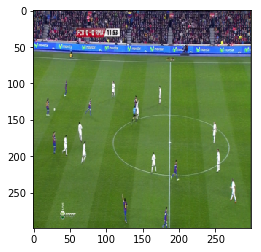

a bunch of different colored toothbrushes are on display
a bunch of different colored toothbrushes are on a table
a bunch of different types of scissors on a table .
a bunch of different colored toothbrushes are on display
a display of a variety of tools and a bottle of wine .
a bunch of different types of scissors on a table .
a bunch of scissors that are on a table
a bunch of urinals that are on a table .
a display of a variety of tools and a glass of wine .
a bunch of toothbrushes that are on a table


In [41]:
for im in os.listdir("my_pics"):
    img = plt.imread("my_pics/" + im)
    img = imresize(img, (299, 299)).astype('float32') / 255.

    plt.imshow(img)
    plt.show()

    for i in range(10):
        print(' '.join(generate_caption(img, t=5.)[1:-1]))

As one can see, nevertheless loss fro training is quite small, the captioning is far away from perfect.
So some simple images of skaterboard or cow or ski network works fine. For a bit more complex, such as river or rocket(looks like it does not now word rocket) is works worse, but still generate something valable. For event more complex pictures of cars or dog, it catches some correct context, but sentence in general is wrong. And finally for Formula 1 or football it generatees comple rubbish.

Interesting is the photo of hedgehog - I all the time I was playing with network and training it never ever showed me anything meaningfull for this picture, althought, it looks very simple to me. The reason for this is either some bug or the fact that I need net for longer?

### Now what?

Your model produces some captions but you still strive to improve it? You're damn right to do so. Here are some ideas that go beyond simply "stacking more layers". The options are listed easiest to hardest.

##### Subword level captioning
In the base version, we replace all rare words with UNKs which throws away a lot of information and reduces quality. A better way to deal with vocabulary size problem would be to use Byte-Pair Encoding

* BPE implementation you can use: [github_repo](https://github.com/rsennrich/subword-nmt). 
* Theory: https://arxiv.org/abs/1508.07909
* It was originally built for machine translation, but it should work with captioning just as well.

##### Attention
You can build better and more interpretable captioning model with attention.
* How it works: https://distill.pub/2016/augmented-rnns/
* One way of doing this in captioning: https://arxiv.org/abs/1502.03044
* You will have to create a dataset for attention with [this notebook](https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b).

#### Reinforcement learning
* After your model has been pre-trained in a teacher forced way, you can tune for captioning-speific models like CIDEr.
* Tutorial on RL for sequence models: [practical_rl week8](https://github.com/yandexdataschool/Practical_RL/tree/master/week8_scst)
* Theory: https://arxiv.org/abs/1612.00563

In [42]:
# with open("part_2_net_v2.pt", 'wb') as f:
#     torch.save(network, f)

/home/shirobokov/.local/lib/python3.6/site-packages/torch/serialization.py:159: UserWarning: Couldn't retrieve source code for container of type CaptionNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
